In [77]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
from statsmodels.regression.linear_model import OLS 
import matplotlib.pyplot as plt 
import order_book_calculations as obc 
df = pd.read_excel('order_book_data.xlsx')

# OrderFlow imbalance (OFI)<br>
## These measures determine the supply and demand on the orderbook<br>
-  OFI: Measures the orders that were executed

_____
Rama Cont, Arseniy Kukanov and Sasha Stoikov
March 2011
*  Our study reveals a linear
relation between order flow imbalance
* a slope inversely proportional
to the market depth
* There is ample evidence that limit orders play an important role in determining price dynamics. 
* OFI represents net order flow at the bid and ask and track changes in teh size of the bid ask queues by 
    * increasing every thime the bid size increases, the ask size decreases, or the bid/ask price increases 
    * decreases every thime the bids size decreases, the ask size increases, or the bid/ask prices decrease 
    * intraday seasonality 
    * Given: 
        * PB_(n-1) = bid price 
        * qB_(n-1) = bid volume 
        * PA_(n-1) = ask price 
        * qA_(n-1) = ask volume 
    where:
        * Demand Increase : PB_(n) > PB_(n-1) or qB_(n) > qB_(n-1)  bid_price increased or bid volume increase
        * Demand Decrease : PB_(n) < PB_(n-1) or qB_(n) < qB_(n-1)  bid_price decreased or bid volume decreasd
        * Supply Increase: PA_(n) < PA_(n-1) or qA_(n) > qA_(n-1)   ask_price decreased or ask volume increased
        * Supply Decrease: PA_(n) > PA_(n-1) or qA_(n) < qA_(n-1)   ask_price increased or ask volume decreased 

    * e_n = contribution of the n-th event to the size of the bid and ask queues: 
        * given by : 
            * I{PB_(n) > PB_(n-1)}qB_(n) - I{PB_(n) < PB_(n-1)}qB_(n-1) - I{PA_(n) < PA_(n-1)}qA_(n) + I{PA_(n) > PA_(n-1)}qA_(n-1)
    * OFI_(k) = Sigma_Sum(en), where en is the sum over the interval k, where interval k is the distance of [t_(k-1), t_(k)]
    * Mid Price changes:
        * given by:
            * Delta P_(k)  = (P_(k) - P_(k-1))/S
            * where:
                * S = tick size 
                * P_(K) = mid-quote pirce at time t_(k)



# OrderFlow:

In [78]:
ob_analysis = obc.OBanalysis()
df = ob_analysis.ofi(df)
df.dropna(inplace = True)

c:\Users\oscar\anaconda3\envs\master\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.001  
Dependent Variable: mid-price-change AIC:                443.1392
Date:               2022-12-11 14:09 BIC:                449.0926
No. Observations:   145              Log-Likelihood:     -219.57 
Df Model:           1                F-statistic:        0.8135  
Df Residuals:       143              Prob (F-statistic): 0.369   
R-squared:          0.006            Scale:              1.2270  
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const      -0.1734     0.2156   -0.8045   0.4224   -0.5996   0.2527
OFI         0.1072     0.1188    0.9019   0.3686   -0.1277   0.3421
-----------------------------------------------------------------
Omnibus:              11.315       Durbin-Watson:          3.161 
Prob(Omnibus):   

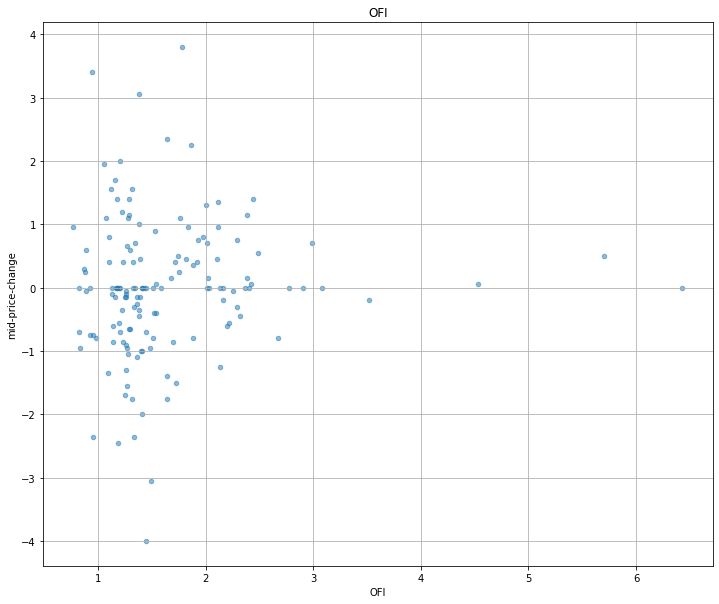

In [83]:
ob_analysis.plot_ofi_and_ols_summary(x)